## 📦 Install Dependencies
This cell installs all required packages such as `yfinance`, `transformers`, and `scikit-learn`.

In [ ]:
!pip install yfinance transformers datasets scikit-learn matplotlib --quiet

## 🧱 Import Libraries
We import the necessary libraries for data handling, modeling, and visualization.

In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

ticker = "MSFT"
data = yf.download(ticker, start="2015-01-01", end="2025-05-18")
data = data[["Close"]].reset_index(drop=True)

scaler = MinMaxScaler()
data["Close"] = scaler.fit_transform(data[["Close"]])


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


## 🧱 Import Libraries
We import the necessary libraries for data handling, modeling, and visualization.

In [ ]:
import numpy as np

# Create sequences for input and label
context_length = 30
prediction_length = 1

past_values = []
future_values = []

for i in range(len(data) - context_length - prediction_length):
  past = data["Close"].values[i:i+context_length]
  future = data["Close"].values[i+context_length:i+context_length+prediction_length]
  past_values.append(past)
  future_values.append(future)

past_values = np.array(past_values)
future_values = np.array(future_values)

print("Past shape:", past_values.shape) # (num_samples, 30)
print("Future shape:", future_values.shape) # (num_samples, 1)


Past shape: (2578, 30, 1)
Future shape: (2578, 1, 1)


## 🔨 Dataset Creation
Dataset function for Time-series analysis

In [ ]:
import torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
  def __init__(self, past_values, future_values):
    self.past_values = torch.tensor(past_values, dtype=torch.float32)
    self.future_values = torch.tensor(future_values, dtype=torch.float32)

  def __len__(self):
    return len(self.past_values)

  def __getitem__(self, idx):
    return {
      "past_values": self.past_values[idx],
      "future_values": self.future_values[idx],
  }

# Split into training and test datasets
split_index = int(0.8 * len(past_values))

train_dataset = TimeSeriesDataset(past_values[:split_index], future_values[:split_index])
test_dataset = TimeSeriesDataset(past_values[split_index:], future_values[split_index:])


## ✅ Model
Distilbert Model from HuggingFace

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig

# Load base DistilBERT model (we'll reshape our numerical data to work with it)
model = AutoModelForSequenceClassification.from_pretrained(
  "distilbert-base-uncased",
  num_labels=1, # regression task
  problem_type="regression"
)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 🔁 Utility Functions
This function helps in converting sequences to readable strings.

In [ ]:
def convert_sequence_to_string(sequence):
  return " ".join([f"{float(x):.4f}" for x in sequence])

train_texts = [convert_sequence_to_string(seq) for seq in past_values[:split_index]]
test_texts = [convert_sequence_to_string(seq) for seq in past_values[split_index:]]

train_labels = future_values[:split_index].flatten()
test_labels = future_values[split_index:].flatten()

<ipython-input-10-e50cf5edc76f>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return " ".join([f"{float(x):.4f}" for x in sequence])


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors="pt")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## 📊 Custom Dataset Class
Defines a PyTorch Dataset for regression-style prediction with transformers.

In [ ]:
class RegressionDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = torch.tensor(labels, dtype=torch.float32)

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    item = {key: val[idx] for key, val in self.encodings.items()}
    item["labels"] = self.labels[idx]
    return item

train_dataset = RegressionDataset(train_encodings, train_labels)
test_dataset = RegressionDataset(test_encodings, test_labels)


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./drive/MyDrive",
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10
  )


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
  )


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.000500,0.191272
2,0.000500,0.173302
3,0.000500,0.148591
4,0.000500,0.150052
5,0.000400,0.152812
6,0.000400,0.154886
7,0.000400,0.150335
8,0.000400,0.154499
9,0.000300,0.154980
10,0.000300,0.155425


TrainOutput(global_step=650, training_loss=0.00048616327130450654, metrics={'train_runtime': 279.555, 'train_samples_per_second': 73.76, 'train_steps_per_second': 2.325, 'total_flos': 789553709262240.0, 'train_loss': 0.00048616327130450654, 'epoch': 10.0})

In [ ]:
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.flatten()
labels = predictions.label_ids.flatten()


In [ ]:
# Undo normalization
preds_real = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
labels_real = scaler.inverse_transform(labels.reshape(-1, 1)).flatten()

## Evaluation
R-squared and Mean Squared Error Analysis

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

print("R² Score:", r2_score(labels_real, preds_real))
print("Mean Squared Error:", mean_squared_error(labels_real, preds_real))

R² Score: -14.255975723266602
Mean Squared Error: 28663.859375


## 🧱 Visualization
See the prediction

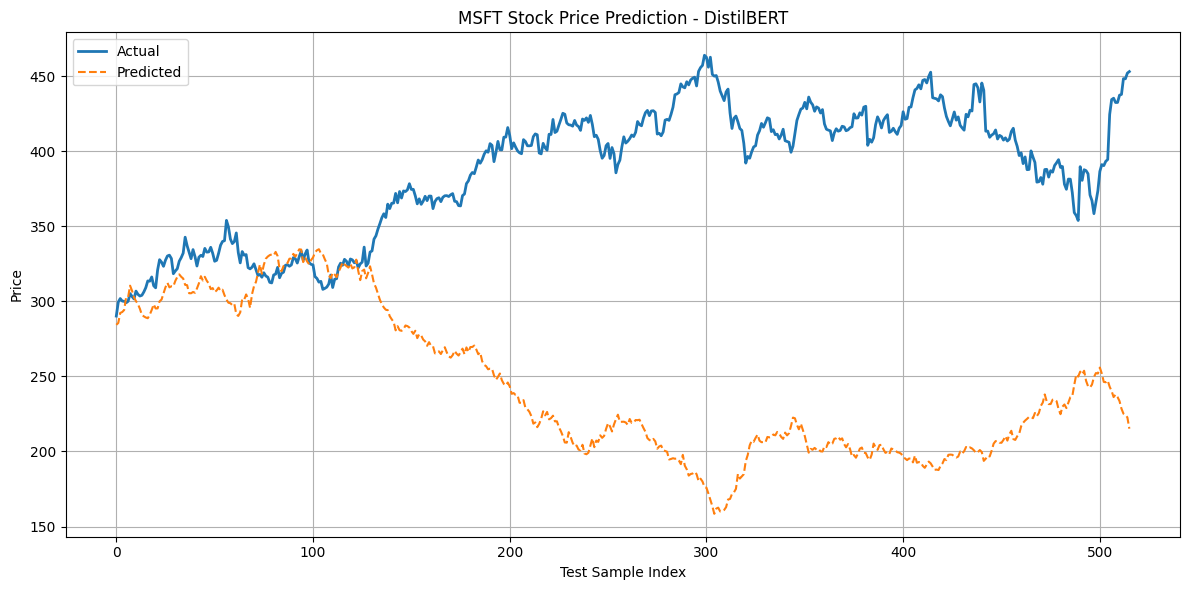

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(labels_real, label="Actual", linewidth=2)
plt.plot(preds_real, label="Predicted", linestyle="--")
plt.title("MSFT Stock Price Prediction - DistilBERT")
plt.xlabel("Test Sample Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()